In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN/SincKAN_old/')  # Add the directory to Python's path

from SincKANLayer import SincKANLayer



Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from SincKANLayer import SincKANLayer


In [ ]:
# Define target function (piecewise function)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:
# Define target function highly oscillatory function (1/x) * cos(log(x)/x)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x <= 0
    y[mask1] = 0
    mask2 = x > 0
    y[mask2] = (1/x[mask2]) * np.cos(np.log(x[mask2])/x[mask2])


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:
# Define target function (sqrt(x))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = x >= 0
    y[mask2] = x[mask2]**0.5


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:
# Define target function (x**0.5 * (1-x)**(3/4))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = (0 <= x) & (x <= 1)
    y[mask2] = x[mask2]**0.5 * (1-x[mask2])**(3/4)
    mask3 = x > 1
    y[mask3] = 0


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:
# Define target function (exp(-x/0.01))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x >= 0
    y[mask1] = np.exp(-x[mask1]/0.01)




    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:


# Define MLP and SincKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1)  # centralize the input


class SincKAN(nn.Module):
    def __init__(self):
        super(SincKAN, self).__init__()
        self.Sinckan1 = SincKANLayer(1, 16, 16)
        self.Sinckan2 = SincKANLayer(16, 1, 16)

    def forward(self, x):
        x = self.Sinckan1(x)
        x = self.Sinckan2(x)
        return x

In [ ]:
import time

# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_target, y_train = target_function(x_train)
y_target, y_train = torch.tensor(y_target, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)


Sinc_model = SincKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_Sinc = torch.optim.Adam(Sinc_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

Sinc_losses = []
mlp_losses = []

# Start the timer
start_time = time.time()

# Train the models
epochs = 8000
l2_lambda = 0  # L2 regularization factor

for epoch in range(epochs):
    optimizer_Sinc.zero_grad()
    outputs_Sinc = Sinc_model(x_train)
    loss_Sinc = criterion(outputs_Sinc, y_train)
    l2_norm_Sinc = sum(p.pow(2.0).sum() for p in Sinc_model.parameters())
    loss_Sinc += l2_lambda * l2_norm_Sinc
    loss_Sinc_gen = criterion(outputs_Sinc, y_target)
    loss_Sinc.backward()
    optimizer_Sinc.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    l2_norm_mlp = sum(p.pow(2.0).sum() for p in mlp_model.parameters())
    loss_mlp += l2_lambda * l2_norm_mlp
    loss_mlp_gen = criterion(outputs_mlp, y_target)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        Sinc_losses.append(loss_Sinc.item())
        mlp_losses.append(loss_mlp.item())

        print(f'Epoch {epoch + 1}/{epochs}, SincKAN training Loss: {loss_Sinc.item():.4e}, '
              f'MLP training Loss: {loss_mlp.item():.4e}')
        print(f'Epoch {epoch + 1}/{epochs}, SincKAN Loss to original function: {loss_Sinc_gen.item():.4e}, '
              f'MLP Loss to original function: {loss_mlp_gen.item():.4e}')
        print()

# End the timer and calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

# Test the models
#x_test = torch.linspace(0, 2, steps=500).unsqueeze(1)
x_test = x_train
y_pred_Sinc = Sinc_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# # Access the value of self.h after training
# trained_h1 = Sinc_model.Sinckan1.h.item()
# trained_h2 = Sinc_model.Sinckan2.h.item()
# print("Value of h in Sinckan1 after training:", trained_h1)
# print("Value of h in Sinckan2 after training:", trained_h2)

Epoch 1/8000, SincKAN training Loss: 9.6723e-01, MLP training Loss: 1.1714e+00
Epoch 1/8000, SincKAN Loss to original function: 9.6539e-01, MLP Loss to original function: 1.1693e+00

Epoch 101/8000, SincKAN training Loss: 4.9195e-04, MLP training Loss: 9.0140e-04
Epoch 101/8000, SincKAN Loss to original function: 5.0146e-04, MLP Loss to original function: 7.6555e-04

Epoch 201/8000, SincKAN training Loss: 2.4834e-03, MLP training Loss: 5.5478e-04
Epoch 201/8000, SincKAN Loss to original function: 2.5560e-03, MLP Loss to original function: 4.3110e-04

Epoch 301/8000, SincKAN training Loss: 5.8603e-05, MLP training Loss: 5.1134e-04
Epoch 301/8000, SincKAN Loss to original function: 5.1153e-05, MLP Loss to original function: 3.8896e-04

Epoch 401/8000, SincKAN training Loss: 1.5483e-04, MLP training Loss: 4.7068e-04
Epoch 401/8000, SincKAN Loss to original function: 1.2878e-04, MLP Loss to original function: 3.4931e-04

Epoch 501/8000, SincKAN training Loss: 6.2986e-05, MLP training Loss:

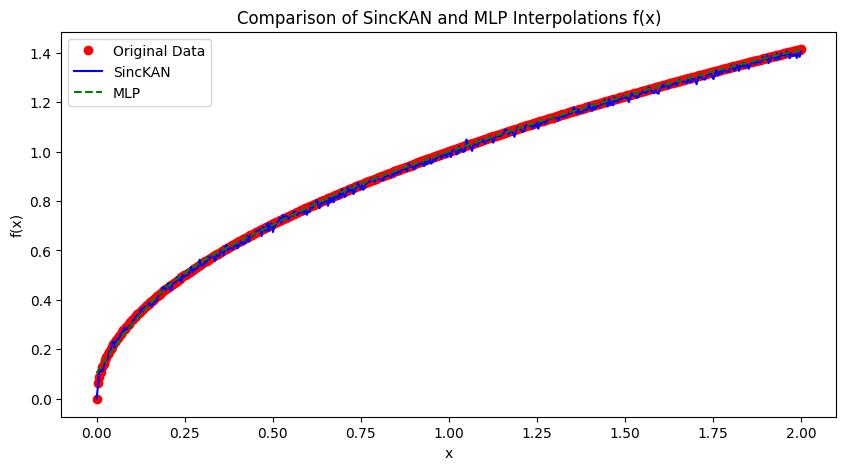

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5)) #更小的计算量，更少的运算时间，精度可比较甚至更佳
plt.plot(x_train.numpy(), y_target.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_Sinc.numpy(), 'b-', label='SincKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of SincKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

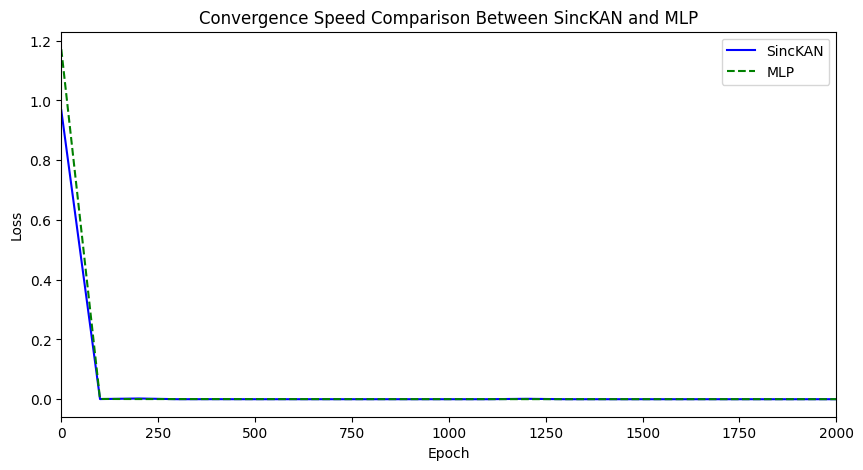

In [ ]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), Sinc_losses, 'b-', label='SincKAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between SincKAN and MLP')
plt.xlim(0, 2000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()